In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMBA_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

In [ ]:
import pickle
import torch
import umap

import seaborn as sns
import midaa as maa
import scanpy as sc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I) Vizualisation of data

In [12]:
input_distribution = ["G", "G"] # Gaussian for both modalities because normalized data

In [ ]:
rna_mod = sc.read_h5ad("data/9NewsGroups_annData_Normalized.h5ad")
atac_mod = sc.read_h5ad("data/9ng_atac_like.h5ad")

atac_mod

AnnData object with n_obs × n_vars = 11314 × 1000
    obs: 'n_words', 'percent_stopwords', 'n_chars', 'category'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'category_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

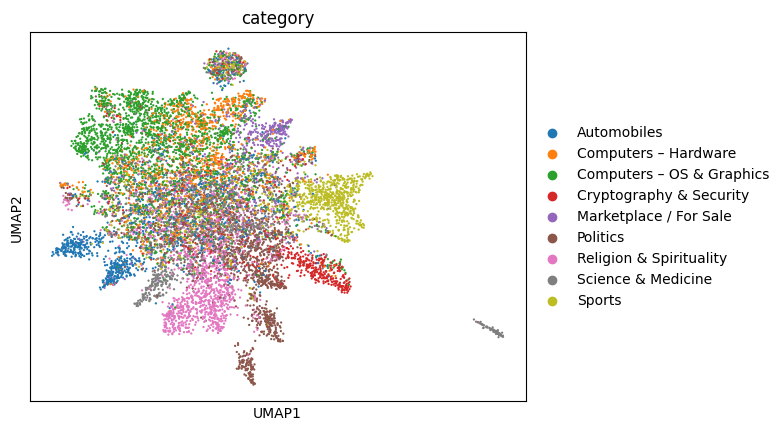

In [10]:
sc.pl.umap(atac_mod, color="category")

In [ ]:
# Ensure reproducibility
np.random.seed(42)

y = rna_mod.obs["category"].values

# Train/Test split
train_idx, test_idx = train_test_split(
    np.arange(rna_mod.n_obs),
    test_size=0.20,
    shuffle=True,
    random_state=42,
    stratify=y # Stratisfy over categories
)

rna_train = rna_mod[train_idx].copy()
rna_test = rna_mod[test_idx].copy()

atac_train = atac_mod[train_idx].copy()
atac_test = atac_mod[test_idx].copy()

# Prepare MIDAA input format (both modalities)
train_set = [rna_train.X, atac_train.X]
normalization_train = [np.ones(rna_train.X.shape[0]), np.ones(atac_train.X.shape[0])]

test_set = [torch.tensor(rna_test.X.toarray() 
                         if hasattr(rna_test.X, "toarray") 
                         else rna_test.X, dtype=torch.float32), 
                         torch.tensor(atac_test.X.toarray() 
                         if hasattr(atac_test.X, "toarray") 
                         else atac_test.X, dtype=torch.float32)]
normalization_test = [np.ones(rna_test.X.shape[0]), np.ones(atac_test.X.shape[0])]


In [30]:
model = maa.fit_MIDAA(train_set,
    normalization_train,
    input_distribution,
    lr=0.001,
    steps=2500, # result from previous study
    narchetypes=5)

ELBO: 52509092.00000  : 100%|██████████| 2500/2500 [57:09<00:00,  1.37s/it]    
/opt/miniconda3/envs/MIDAA/lib/python3.11/site-packages/pyro/primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


# II) Training

In [ ]:
deepAA = model["deepAA_obj"]
model_to_save = {
    "inferred_quantities": model["inferred_quantities"],
    "hyperparameters": model["hyperparameters"],
    "ELBO": model["ELBO"]
}
with open(f"model_save/model_5_metadata.pkl", "wb") as f:
    pickle.dump(model_to_save, f)

torch.save(deepAA.state_dict(), f"model_save/model_5_weights.pt")

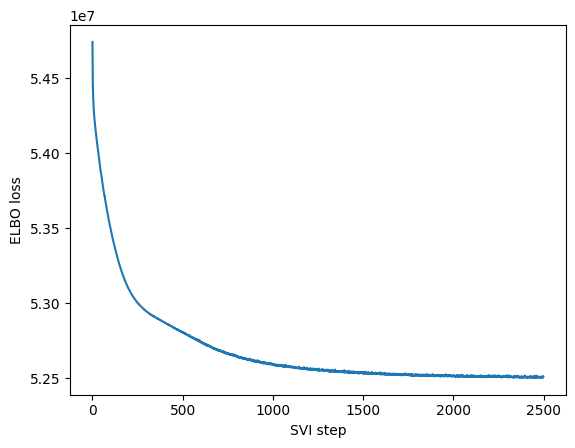

In [32]:
maa.plot_ELBO(model)

# III) Choose number of archetypes: Elbow Methods

In [ ]:
models = {}

for i in tqdm[int](range(2, 8)): # Between 2 and 7 archetypes 
    model = maa.fit_MIDAA(train_set,
    normalization_train,
    input_distribution,
    lr=0.001,
    steps=2000, # result from previous study
    narchetypes=i)

    models[i]=model
    

    deepAA = model["deepAA_obj"]
    model_to_save = {
        "inferred_quantities": model["inferred_quantities"],
        "hyperparameters": model["hyperparameters"],
        "ELBO": model["ELBO"]
    }

    with open(f"model_save/model_{i}_metadata.pkl", "wb") as f:
        pickle.dump(model_to_save, f)

    torch.save(deepAA.state_dict(), f"model_save/model_{i}_weights.pt")

  0%|          | 0/6 [00:00<?, ?it/s]

ELBO: 54314056.00000  :   0%|          | 10/2000 [00:13<45:38,  1.38s/it]


KeyboardInterrupt: 

## Load models

In [ ]:
models = {}
for i in range(2,8):
    with open(f"model_save/multimodal/model_{i}_metadata.pkl", "rb") as f:
            model=pickle.load(f)

    model["deepAA_obj"] = torch.load(f"model_save/multimodal/model_{i}_weights.pt")
    models[i]=model

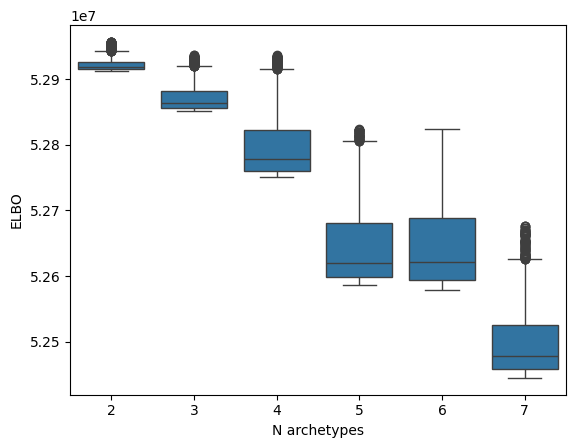

In [6]:
maa.plot_ELBO_across_runs(models)

# IV) Results

In [ ]:
model[5]["ELBO"][-1]

array(52453024., dtype=float32)

(<Figure size 640x480 with 1 Axes>, <PolarAxes: >)

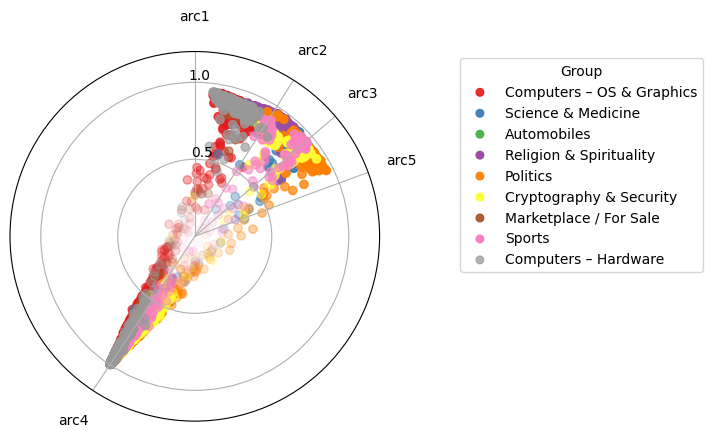

In [21]:
maa.plot_archetypes_simplex(model, color_by=atac_train.obs["category"], cmap='Set1')

(<Figure size 1500x1500 with 9 Axes>,
 array([<PolarAxes: title={'center': 'Group: Computers – OS & Graphics'}>,
        <PolarAxes: title={'center': 'Group: Science & Medicine'}>,
        <PolarAxes: title={'center': 'Group: Automobiles'}>,
        <PolarAxes: title={'center': 'Group: Religion & Spirituality'}>,
        <PolarAxes: title={'center': 'Group: Politics'}>,
        <PolarAxes: title={'center': 'Group: Cryptography & Security'}>,
        <PolarAxes: title={'center': 'Group: Marketplace / For Sale'}>,
        <PolarAxes: title={'center': 'Group: Sports'}>,
        <PolarAxes: title={'center': 'Group: Computers – Hardware'}>],
       dtype=object))

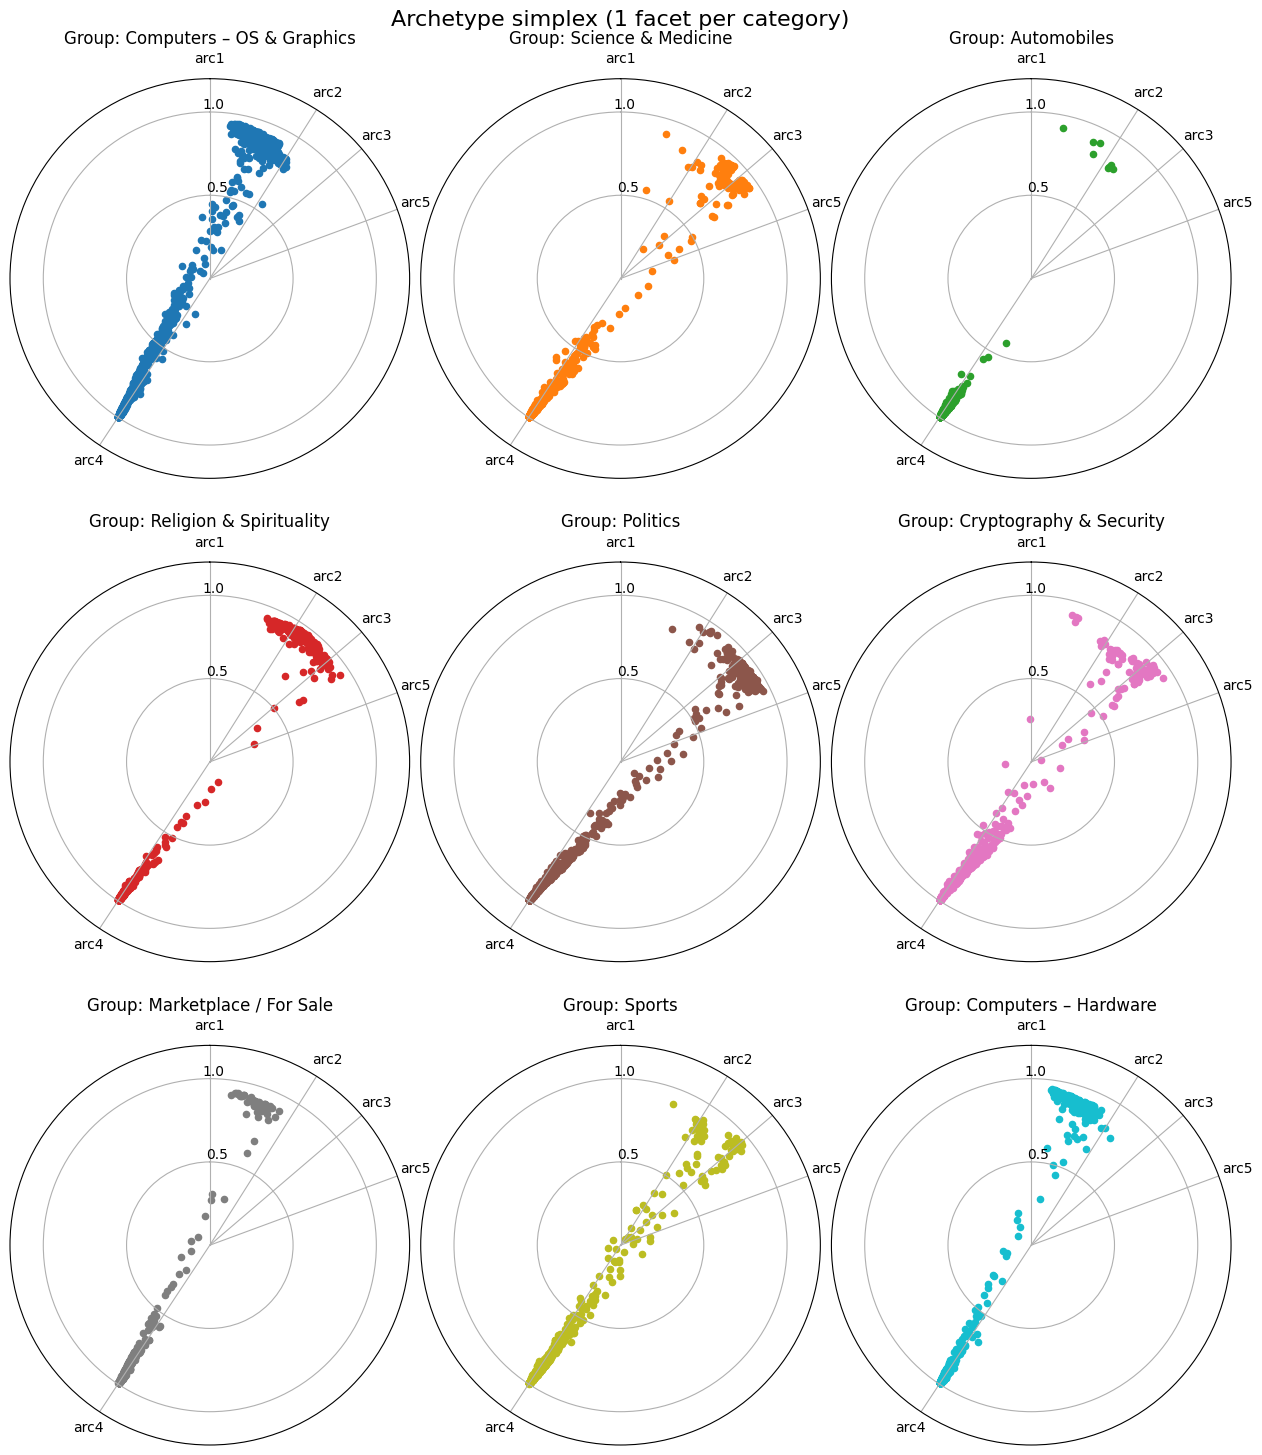

In [ ]:
import scipy
from python_tsp.exact import solve_tsp_dynamic_programming

def plot_archetypes_simplex_facets(
    res,
    distance_type="euclidean",
    cmap="nipy_spectral",
    color_by=None,
    subsample=None,
    s=20,
    figsize=(15, 15),
    l_title="Group"
):
    """
    Same geometry as plot_archetypes_simplex but creates one subplot per category.
    Points are NOT colored by theta anymore — but uniformly by category.
    """

    # -------------------------
    # 1) Compute the same geometry (theta, r)
    # -------------------------
    if subsample is not None:
        arcs = res["inferred_quantities"]["A"][subsample, :]
    else:
        arcs = res["inferred_quantities"]["A"]

    dist_matrix = scipy.spatial.distance.cdist(arcs.T, arcs.T, distance_type)
    permutation, distance = solve_tsp_dynamic_programming(dist_matrix)

    dists = []
    for i in range(1, len(permutation)):
        dists.append(dist_matrix[permutation[i - 1], permutation[i]])
    dists.append(dist_matrix[permutation[-1], permutation[0]])
    dists = np.array(dists)
    dists /= dists.sum()

    labels = 360 * dists
    labels = labels.cumsum()[:-1]
    labels = np.append(0, labels)
    labels_rad = np.radians(labels)

    A = res["inferred_quantities"]["A"][:, permutation]

    r = np.sqrt((A * np.cos(labels_rad)).sum(axis=1)**2 +
                (A * np.sin(labels_rad)).sum(axis=1)**2)
    theta = np.arctan2(
        (A * np.sin(labels_rad)).sum(axis=1),
        (A * np.cos(labels_rad)).sum(axis=1)
    )

    arc_names = [f"arc{i+1}" for i in permutation]

    # -------------------------
    # 2) If no color_by → default single plot
    # -------------------------
    if color_by is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='polar')
        ax.scatter(theta, r, color="steelblue", s=s)  # FIX: uniform color
        ax.set_thetagrids(labels, arc_names)
        ax.set_rmax(1.2)
        ax.grid(True)
        return fig, ax
    
    # Multi-subplot: 1 per category
    unique_vals = list(color_by.unique())
    n = len(unique_vals)

    fig, axes = plt.subplots(
        3, 3,
        figsize=(figsize[0], figsize[1]),
        subplot_kw={"projection": "polar"}
    )
    axes = axes.flatten()

    palette = plt.cm.tab10(np.linspace(0, 1, len(unique_vals)))
    color_map = {val: palette[i] for i, val in enumerate(unique_vals)}

    for ax, val in zip(axes, unique_vals):

        idx = color_by == val

        ax.scatter(theta[idx], r[idx], color=color_map[val], s=s)

        ax.set_thetagrids(labels, arc_names)
        ax.set_rmax(1.2)
        ax.set_rticks([0.5, 1])
        ax.set_rlabel_position(-2.5)
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.grid(True)

        ax.set_title(f"{l_title}: {val}")

    fig.suptitle("Archetype simplex (1 facet per category)", fontsize=16)
    fig.subplots_adjust(top=0.2)
    plt.tight_layout()

    return fig, axes

plot_archetypes_simplex_facets(model, color_by=atac_train.obs["category"], cmap='Set1')

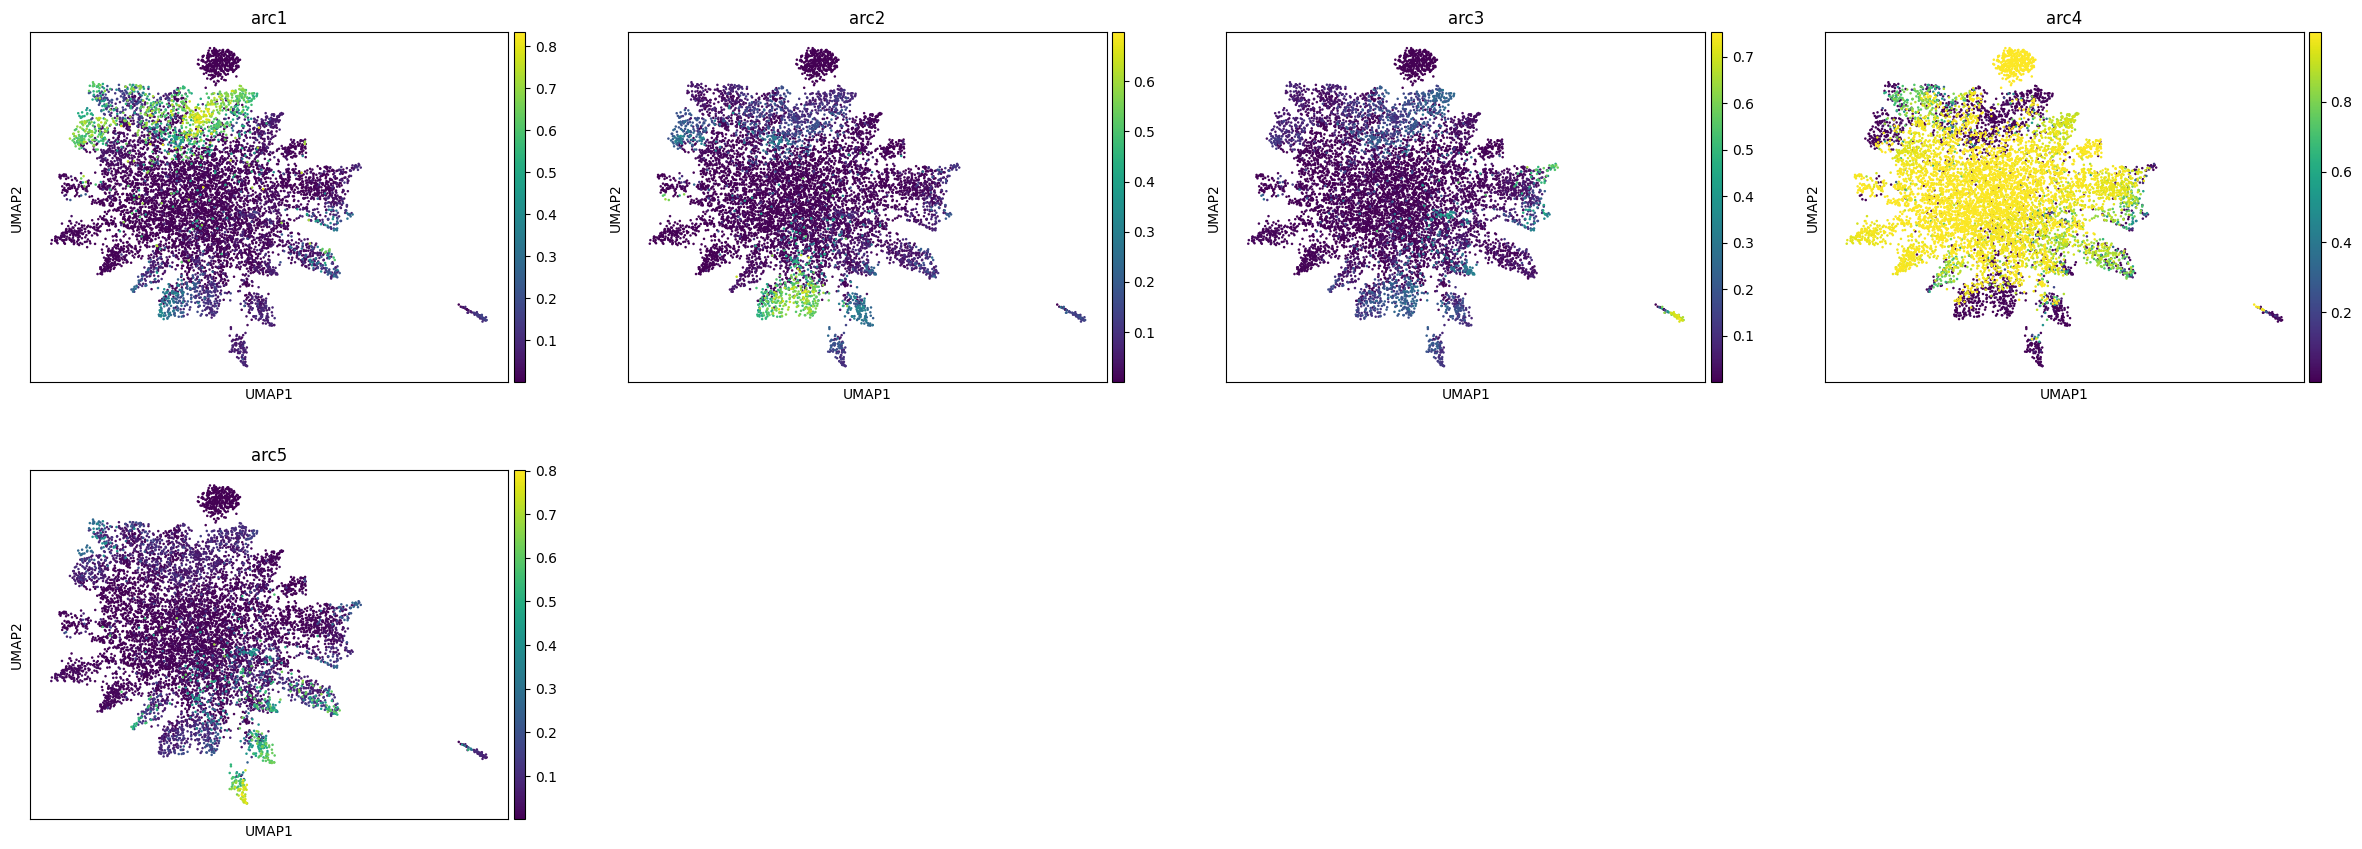

In [22]:
adata_train, arc_names = maa.add_to_obs_adata(model, atac_train)
sc.pl.umap(adata_train, color = arc_names)

/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


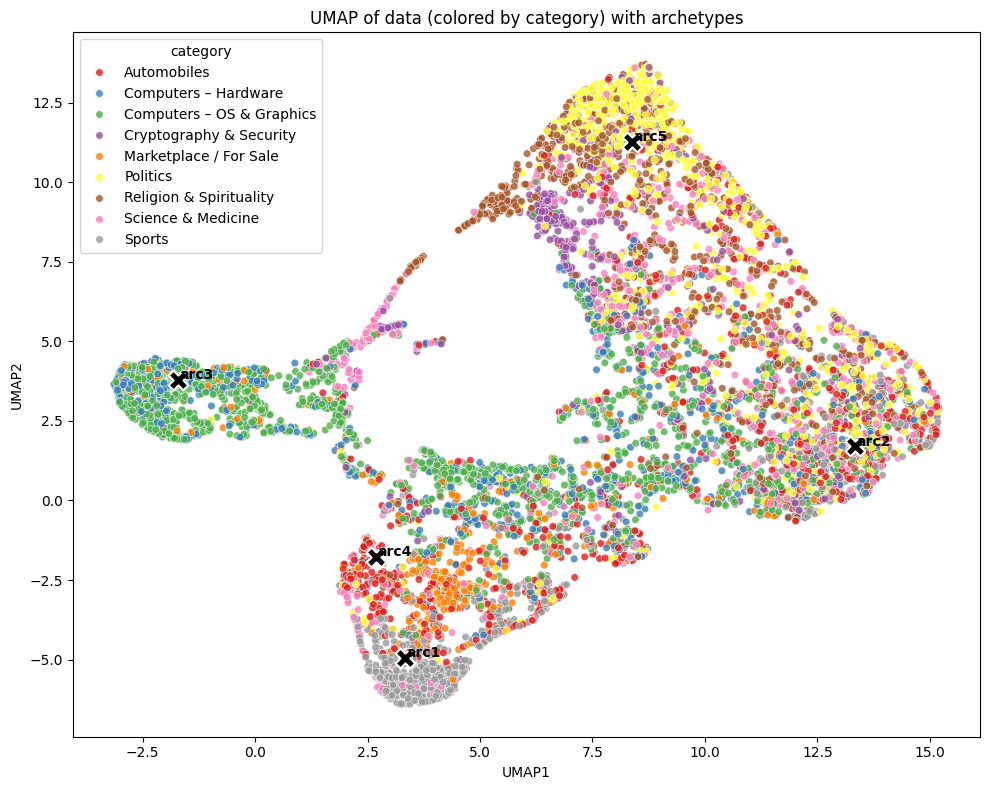

In [ ]:
def plot_umap_data_and_archetypes(model, categories, palette="Set1",
                                  n_neighbors=15, min_dist=0.1, metric="euclidean"):
    """
    2D UMAP of the latent space   
    """
    # Get data and archetypes in same feature space
    Z = model["inferred_quantities"]["Z"]                    # (N, d)
    A = model["inferred_quantities"]["archetypes_inferred"]  # (K, d)

    N = Z.shape[0]
    K = A.shape[0]

    # Stack data + archetypes so UMAP learns a joint embedding
    X_all = np.vstack([Z, A])  

    # UMAP 2D
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_all = reducer.fit_transform(X_all)

    Z_umap = emb_all[:N]        
    A_umap = emb_all[N:]        

    df = pd.DataFrame({
        "UMAP1": Z_umap[:, 0],
        "UMAP2": Z_umap[:, 1],
        "category": categories.values
    })

    plt.figure(figsize=(10, 8))
    ax = sns.scatterplot(
        data=df,
        x="UMAP1",
        y="UMAP2",
        hue="category",
        palette=palette,
        alpha=0.8,
        s=30,
    )

    # Overlay archetypes
    sns.scatterplot(
        x=A_umap[:, 0],
        y=A_umap[:, 1],
        s=200,
        marker="X",
        color="black",
        edgecolor="white",
        linewidth=1.5,
        ax=ax,
        legend=False,
    )

    # Label archetypes
    for i, (x, y) in enumerate(A_umap):
        plt.text(x + 0.02, y + 0.02, f"arc{i+1}", fontsize=10, weight="bold")

    plt.title("UMAP of data (colored by category) with archetypes")
    plt.tight_layout()
    return ax

ax = plot_umap_data_and_archetypes(
    model,
    categories=atac_train.obs["category"],
    palette="Set1"
)

In [ ]:
def plot_umap3d_data_and_archetypes(
    model,
    categories,
    palette="Set1",
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    figsize=(10, 8)
):
    """
    3D UMAP of the latent space   
    """

    Z = model["inferred_quantities"]["Z"]
    A = model["inferred_quantities"]["archetypes_inferred"]

    N = Z.shape[0]
    K = A.shape[0]

    X_all = np.vstack([Z, A])

    reducer = umap.UMAP(
        n_components=3,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_all = reducer.fit_transform(X_all)

    Z_umap = emb_all[:N]
    A_umap = emb_all[N:]

    import seaborn as sns

    cats = pd.Series(categories).reset_index(drop=True)
    unique_cats = cats.unique()
    pal = sns.color_palette(palette, len(unique_cats))
    color_map = {cat: pal[i] for i, cat in enumerate(unique_cats)}
    point_colors = [color_map[c] for c in cats]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(
        Z_umap[:, 0], Z_umap[:, 1], Z_umap[:, 2],
        c=point_colors,
        s=20,
        alpha=0.8
    )

    ax.scatter(
        A_umap[:, 0], A_umap[:, 1], A_umap[:, 2],
        c="white",
        s=500,                 # bigger than marker
        marker="X",
        linewidth=0,
        alpha=1.0,
        zorder=10
    )

    ax.scatter(
        A_umap[:, 0], A_umap[:, 1], A_umap[:, 2],
        c="black",
        s=350,
        marker="X",
        edgecolor="white",
        linewidth=2.5,
        zorder=11
    )

    for i, (x, y, z) in enumerate(A_umap):
        ax.text(
            x, y, z,
            f"arc{i+1}",
            fontsize=14,
            fontweight="bold",
            color="black",
            zorder=12
        )

    # legend
    for cat in unique_cats:
        ax.scatter([], [], [], c=[color_map[cat]], label=cat)
    ax.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")

    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")
    ax.set_zlabel("UMAP-3")
    ax.set_title("UMAP 3D of Z with visible archetypes")

    plt.tight_layout()
    return fig, ax


/opt/anaconda3/envs/MIDAA/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


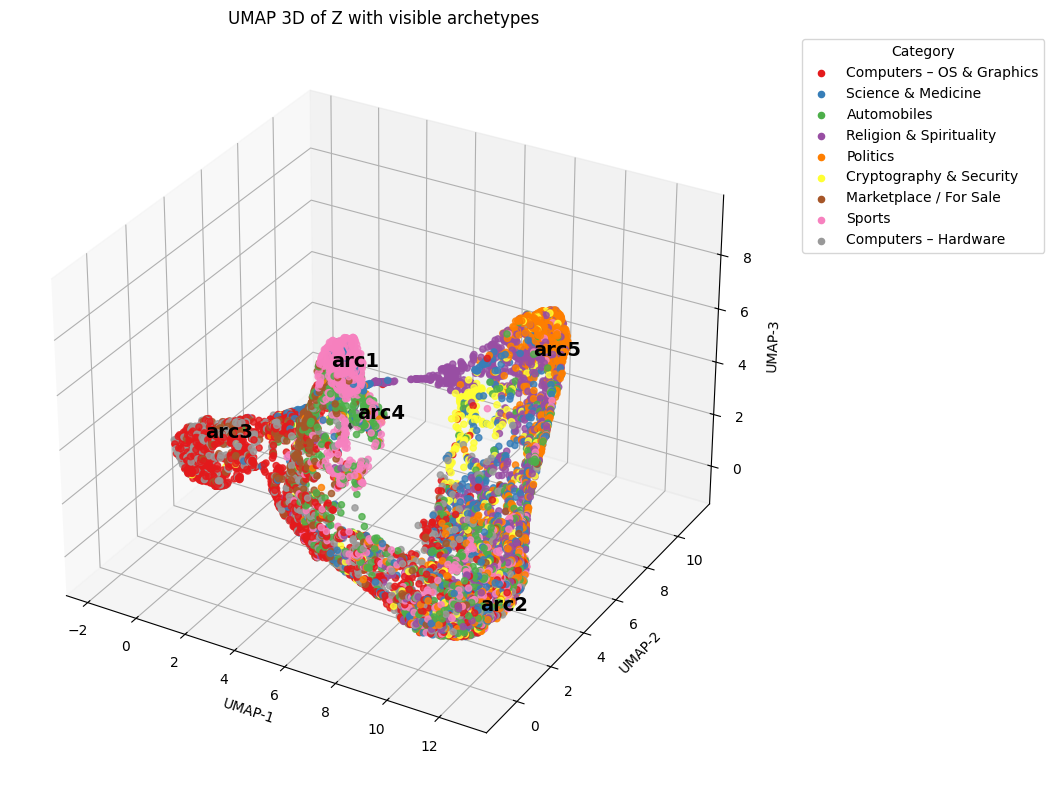

In [10]:
fig, ax = plot_umap3d_data_and_archetypes(
    model,
    categories=atac_train.obs["category"],
    palette="Set1"
)